In [1]:
%reload_ext autoreload
%autoreload 2
%run startup.py

from cpptest import * 

from pytplan import Joint
from pathlib import Path

root_dir = Path('../../..')
test_dir = root_dir/'cmake'/'src'/'test'
cli_dir = test_dir/'system'
unit_dir = test_dir/'unit'

test_files_dir = Path('../../..')/'src'/'test_data'

!ls {test_files_dir}

stepper_file_test.txt


[ 13%] Built target libhost
[ 27%] Built target libfastcrc
[ 81%] Built target libplanner
[ 90%] Built target planner
[100%] Built target stepper
[ 13%] Built target libhost
[ 27%] Built target libfastcrc
[ 81%] Built target libplanner
[ 90%] Built target planner
[100%] Built target stepper
Running ['../../../cmake/src/test/system/planner', '-p', '-j', '--vtime', '200', '--type', 'J']
CPP Time:  136 μs 23 μs per block


  0 0.0000 0.2000|[0        500 100  ↗10000     500 50   ↘375    50    10000] [0        125 50   ↗5000      625 125  ↘94     25     5000]
  1 0.2000 0.2000|[10000      0 0    ↗10000    1500 150  ↘375    50    10000] [5000       0 0    ↗5000      875 175  ↘94     25     5000]
  2 0.4000 0.2000|[10000      0 0    ↗10000    1000 100  ↘500    100       0] [5000       0 0    ↗5000      750 150  ↘125    50        0]


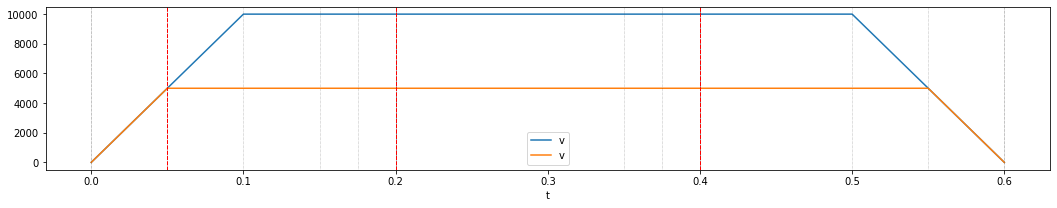

In [110]:
# Jog test

v1 = 10_000
v2 = v1/2
moves = [
    [v1,v2],
    [v1,v2],
    [v1,v2],
    [v1,v2],
    [v1,v2],
    [v1,v2],
    [v1,v2],
]
cp = CPPPlanner(cli_dir)
cp.make()

j = Joint(10000, 100_000)

joints = [j,j]

cp.make()
sl_c = cp.planner(joints, moves, move_time=200, move_type='J')

sl_c.plot()

sl_c


[ 13%] Built target libhost
[ 27%] Built target libfastcrc
Consolidate compiler generated dependencies of target libplanner
[ 31%] Building CXX object src/planner/CMakeFiles/libplanner.dir/stepper.cpp.o
[ 36%] Linking CXX static library liblibplanner.a
[ 81%] Built target libplanner
[ 86%] Linking CXX executable planner
[ 90%] Built target planner
[ 95%] Linking CXX executable stepper
[100%] Built target stepper
Running ['../../../cmake/src/test/system/planner', '-s', '--vtime', '200', '--type', 'J']


(array([5000, 2750]), 0.605475)

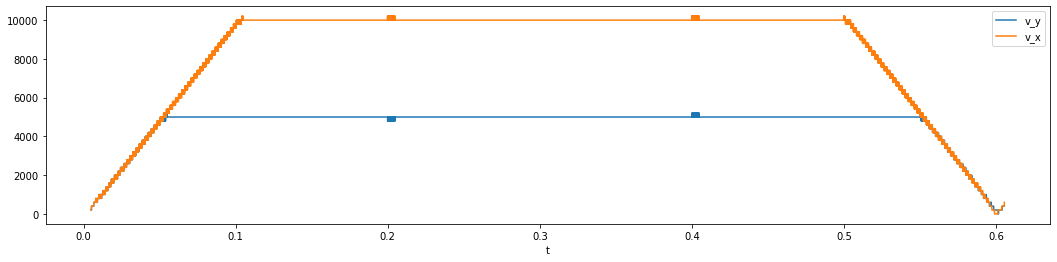

In [204]:
cp.make()
l = cp.run_stepper(joints, moves, move_time=200, move_type='J')

# cpp program runs on time period of 5us, so mult by 1/5us to get actual velocity
p = 1/(5/1e6)

df = pd.DataFrame(l, columns=['t','x','y'])
df['v_y'] = df.y.rolling(1000).mean() * p
df['v_x'] = df.x.rolling(1000).mean() * p

ax=df.plot('t','v_y', figsize=(18,4))
ax=df.plot('t','v_x', ax=ax)

df[['x','y']].sum().values,  df.t.max()


In [201]:
from operator import attrgetter

ig = attrgetter(*'x_a x_c x_d'.split())
#ig = attrgetter(*'v_0 v_c v_1'.split())

ig(sl_c[0][0]), ig(sl_c[0][1])

((500.0, 499.9999999999999, 375.0), (125.0, 625.0, 93.75))

In [191]:
def tf(phase):
    t, x, vi, vf = phase
    t_f = abs((2. * abs(x)) / (vi + vf)) if (vi + vf) != 0 else 0
    return t_f
    

def sb_times(sb):
    pt = sum([tf(phase) for phase in sb])
    st = sb[0][0] + sb[1][0] +  sb[2][0]
    
    return pt, st

def sb_times_split(sb):
    pt = tuple([tf(phase) for phase in sb])
    st = sb[0][0],sb[1][0],sb[2][0]
    
    return pt, st

print(sb_times(sl_c[0][0].stepper_blocks()), sb_times(sl_c[0][1].stepper_blocks()))
print(sb_times_split(sl_c[0][0].stepper_blocks()), sb_times_split(sl_c[0][1].stepper_blocks()))



(0.18750000000000003, 0.2) (0.1938, 0.19999999999999998)
((0.1, 0.05, 0.0375), (0.1, 0.04999999999999999, 0.05)) ((0.05, 0.125, 0.0188), (0.05, 0.125, 0.025))


(array([4750, 2688]), 0.59293)

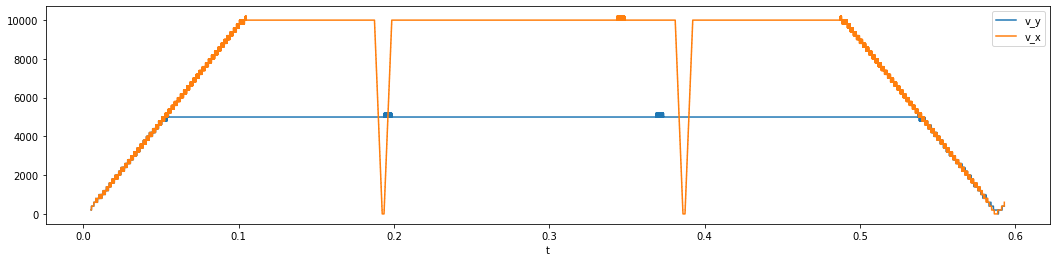

In [147]:
# cpp program runs on time period of 5us, so mult by 1/5us to get actual velocity
p = 1/(5/1e6)

df = pd.DataFrame(l, columns=['t','x','y'])
df['v_y'] = df.y.rolling(1000).mean() * p
df['v_x'] = df.x.rolling(1000).mean() * p

ax=df.plot('t','v_y', figsize=(18,4))
ax=df.plot('t','v_x', ax=ax)

df[['x','y']].sum().values,  df.t.max()

(1.985, 2.005)

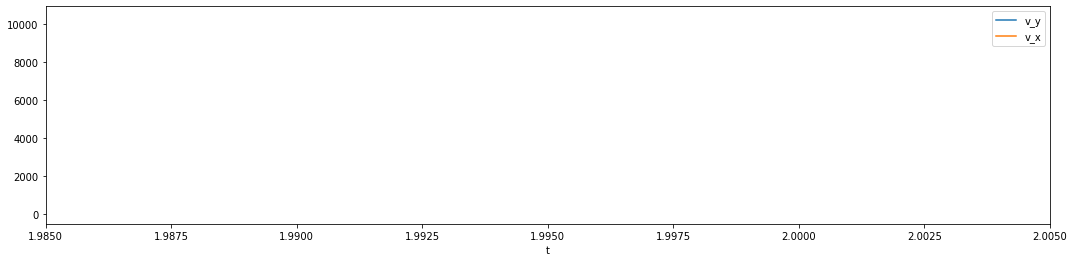

In [113]:
ax=df.plot('t','v_y', figsize=(18,4))
ax=df.plot('t','v_x', ax=ax)

c = 1.995
dt = 0.01
ax.set_xlim(c-dt, c+dt)


<AxesSubplot:>

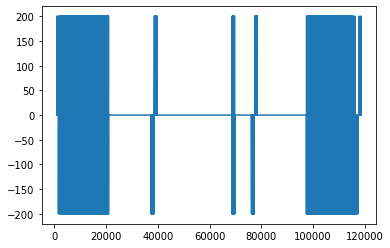

In [150]:
df['v_x'] = df.x.rolling(1000).mean() * p

df['v_x'].diff().plot()


In [114]:
t =df[df.t.between(c-dt, c+dt)]
z = t[t.v_x == 0]
z.t.max(),  z.t.min() , z.t.max() - z.t.min()


(nan, nan, nan)

In [109]:
c = 1.98739
t =df[df.t.between(c-.0001, c+.0001)]
#t[t.v_x == 10000]
z = t[t.v_x == 0]
z.t.max(),  z.t.min() , z.t.max() - z.t.min()

(nan, nan, nan)